# lesson 5

本节看看如何构建地图。包括：

- Static maps
- Interactive Leaflet maps (Folium and mplleaflet)

使用的库包括：

- Matplotlib(与geopandas整合，构建static maps)
- Folium(基于Leaflet构建交互式地图)
- mpleaflet(可以很容易地将matplotlib图转为可交互的leaflet地图)
- contextily(添加basemaps)

## static maps

首先，数据在dataE5文件夹下，有许多shape文件备用。前面也有用到过geopandas的plot方法，它就是调用了matplotlib的pyplot函数。现在再看看新例子：

In [1]:
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
%matplotlib inline

# Filepaths
grid_fp = "dataE5/TravelTimes_to_5975375_RailwayStation.shp"
roads_fp = "dataE5/roads.shp"
metro_fp = "dataE5/metro.shp"

# Read files
grid = gpd.read_file(grid_fp)
roads = gpd.read_file(roads_fp)
metro = gpd.read_file(metro_fp)

绘图前要先检查坐标系是否一致，不一致地要转换到相同坐标系下。

In [2]:
# Check the crs of each layer
print(roads.crs)
print(metro.crs)
print(grid.crs)

{'proj': 'tmerc', 'lat_0': 0, 'lon_0': 24, 'k': 1, 'x_0': 2500000, 'y_0': 0, 'ellps': 'intl', 'units': 'm', 'no_defs': True}
{'proj': 'tmerc', 'lat_0': 0, 'lon_0': 24, 'k': 1, 'x_0': 2500000, 'y_0': 0, 'ellps': 'intl', 'units': 'm', 'no_defs': True}
{'init': 'epsg:3067'}


In [3]:
# Roads and the metro are in an old Finnish crs, while the grid is in ETRS89 / TM35FIN:
print("Roads crs:", CRS(roads.crs).name)
print("Metro crs:", CRS(metro.crs).name)
print("Grid crs: ",CRS(grid.crs).name)

Roads crs: unknown
Metro crs: unknown
Grid crs:  ETRS89 / TM35FIN(E,N)


E:\Programs\anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [4]:
# Reproject geometries to ETRS89 / TM35FIN based on the grid crs:
roads = roads.to_crs(crs=grid.crs)
metro = metro.to_crs(crs=grid.crs)

E:\Programs\anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [5]:
# Now the layers should be in the same crs
roads.crs == metro.crs == grid.crs

True

坐标系转换完成之后，就可以绘图了。

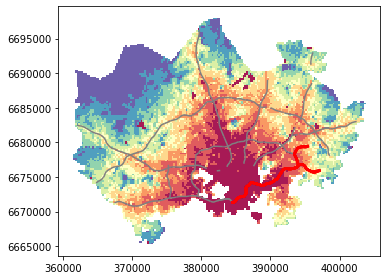

In [6]:
# Visualize the travel times into 9 classes using "Quantiles" classification scheme
my_map = grid.plot(column="car_r_t", linewidth=0.03, cmap="Spectral", scheme="quantiles", k=9, alpha=0.9)

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=my_map, color="grey", linewidth=1.5)

# Add metro on top of the previous map
metro.plot(ax=my_map, color="red", linewidth=2.5)

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

# Save the figure as svg file
outfp = "static_map.svg"
plt.savefig(outfp, format='svg')

从上述代码可以看到，可选的参数有：scheme 定义分类框架，cmap设置地图颜色等。还可以进一步精细控制坐标轴等：

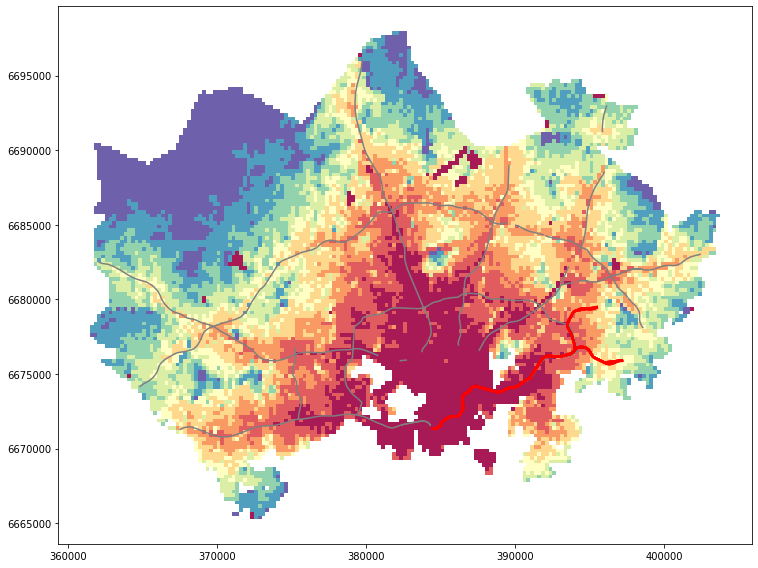

In [7]:
# For better control of the figure and axes, use the plt.subplots function before plotting the layers
# https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html#a-figure-with-just-one-subplot

# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(ax=ax, column="car_r_t", linewidth=0.03, cmap="Spectral", scheme="quantiles", k=9, alpha=0.9)

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=ax, color="grey", linewidth=1.5)

# Add metro on top of the previous map
metro.plot(ax=ax, color="red", linewidth=2.5)

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map2.png"
plt.savefig(outfp, dpi=300)

在实际应用中，我们经常需要将底图加到我们数据上。这项内容可以使用背景map tiles来较容易地实现，map tiles提供者有OpenStreetMap，Stamen Design等。一个叫做contextily的python库可以用来快速地获取地理空间栅格文件并将它们增加到地图中。地图tiles的典型坐标系是 Web Mercator projection (EPSG:3857)。接下来看看如何在上面的数据下放置底图。首先读取数据。

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
%matplotlib inline

# Filepaths
grid_fp = "dataE5/TravelTimes_to_5975375_RailwayStation.shp"

# Read data
grid = gpd.read_file(grid_fp)
grid.head(2)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250.000 6697750.000, 382000.000 6..."


同样需要处理坐标系：

In [9]:
grid.crs

{'init': 'epsg:3067'}

可以看到，需要转换坐标系到ESPG 3857 projection (Web Mercator)

In [10]:
# Reproject to EPSG 3857
data = grid.to_crs(epsg=3857)
data.crs

E:\Programs\anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


{'init': 'epsg:3857', 'no_defs': True}

In [11]:
data.head(2)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((2767221.646 8489079.101, 2766716.966..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((2767726.329 8489095.521, 2767221.646..."


可以看到geometry数据已经变化，坐标已经完成转换了。现在通过使用contextily的.add_basemap()函数可以增加底图到数据上。

ConnectionError: HTTPSConnectionPool(host='stamen-tiles-a.a.ssl.fastly.net', port=443): Max retries exceeded with url: /terrain/12/2327/1180.png (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001F978E51148>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

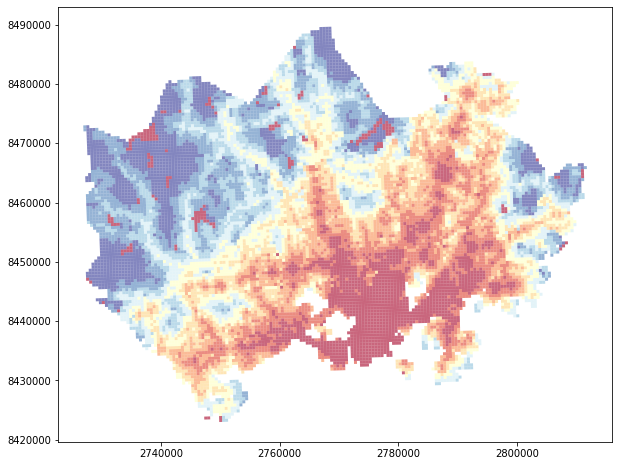

In [12]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Plot the data
data.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap
ctx.add_basemap(ax)

ConnectionError: HTTPConnectionPool(host='a.tile.openstreetmap.org', port=80): Max retries exceeded with url: /12/2327/1184.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001F979024C88>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

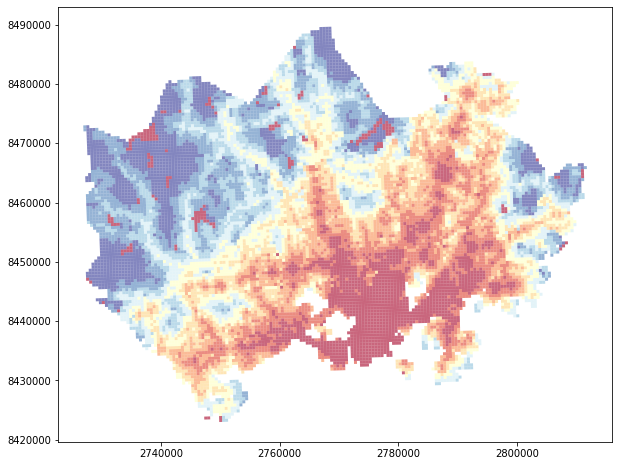

In [13]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Plot the data
data.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap with `ST_TONER` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)